# cw_svmv2

In [1]:
#update opencv; restart runtime
!pip install opencv-python==4.5.5.64
!pip install wandb

     |████████████████████████████████| 60.5 MB 54 kB/s 
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.1.2.30
    Uninstalling opencv-python-4.1.2.30:
      Successfully uninstalled opencv-python-4.1.2.30
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.
     |████████████████████████████████| 1.8 MB 7.9 MB/s 
     |████████████████████████████████| 145 kB 41.0 MB/s 
     |████████████████████████████████| 181 kB 38.0 MB/s 
     |████████████████████████████████| 63 kB 1.1 MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=504944489809e19511a1a46b51639ed789b7a1b9964e4896fca4b2bc4cf66e64
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71

In [2]:
metrics_all = {}

In [3]:
#import libraries
import os
import re
import random
import warnings
import numpy as np
from tqdm.notebook import trange, tqdm
#from tqdm import tqdm, trange
import pandas as pd
from random import randint
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
from skimage import io, transform, img_as_ubyte, color
from skimage.feature import hog
from sklearn import svm, metrics
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler 
from sklearn.model_selection import train_test_split
from sklearn.cluster import MiniBatchKMeans
from sklearn.neural_network import MLPClassifier
import wandb

sns.set_style("whitegrid")


In [5]:
wandb.login()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [4]:
#Mount Google Drive
drive.mount('/content/drive')
GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'Computer Vision Coursework/CW_Folder_PG' 
GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print(os.listdir(GOOGLE_DRIVE_PATH))

Mounted at /content/drive
['.DS_Store', 'Models', 'CW_Dataset', 'Code', 'Video', 'test_functions_scratch.ipynb']


In [6]:
# Identify path to zipped dataset
zip_path = os.path.join(GOOGLE_DRIVE_PATH, 'CW_Dataset/CW_Dataset.zip')

# Copy it to Colab
!cp '{zip_path}' .

# Unzip it
!yes|unzip -q CW_Dataset.zip

# Delete zipped version from Colab (not from Drive)
!rm CW_Dataset.zip

## 📶 Creating the Training and test set

Start by unzipping the images to Colab servers and creating the training and validation sets:


1.   Load images by using `load_images`
2.   Resample training set by `RandomOverSampler()` or `RandomUnderSampler()`
3.   Extract BoVWtraining and test feature descriptors by using the class `SiftBoVW`




              







In [7]:
def load_images(root_dir, label_path):
    """Return an array of images and array of labels.

    Args:
        root_dir (string): Folder containing all the images with sequential numbering.
        label_path (string): Path to text file listing image filenames (sequential) and labels in this order.

    Returns:
        A tuple containing an array of images and an array of labels
    """
    # import filenames and respective labels
    df = pd.read_csv(label_path,
                     delimiter=' ',
                     header=None,
                     names=['filename', 'label'])
    df.sort_values('filename', inplace=True)
    # import images
    images = []
    # !sort image folder
    image_folder = sorted(os.listdir(root_dir))
    # generator to extract each image path
    images_in_folder = (file for file in image_folder if file.endswith('.jpg'))
    count = 0  # index
    for image_path, image_label in zip(images_in_folder, (df['filename'])):
        count += 1  # check if filenames and filenames in labels list are equal
        if re.findall(r'\d+', image_path) == re.findall(r'\d+', image_label):
            image = io.imread(os.path.join(root_dir, image_path))
            images.append(image)
        else:
            print(f'Found unmatched image file {image_path} and label {image_label} \
                at index {count}')
            pass

    return np.array(images), np.array(df['label'])


def plot_classification(true_label,
                        predicted_labels,
                        classifier: str = 'SVM-BoVW',
                        des: str = 'train'):
    """
    Return classification report and plot matrix.
    """
    with warnings.catch_warnings():
        label_axis = ['Surprise', 'Fear', 'Disgust', 'Happiness', 'Sadness', 'Anger', 'Neutral']
        warnings.simplefilter('ignore')
        print(f"""Classification report for classifier {classifier} on {str(des)} set:
          {metrics.classification_report(true_label, predicted_labels)}\n""")
        cm = metrics.confusion_matrix(true_label, predicted_labels)
        sns.heatmap(cm/np.sum(cm), cmap='YlGnBu', annot=True, fmt='.2%', xticklabels=label_axis, yticklabels=label_axis)

In [8]:
#Create training and validation sets
#load images
X, y = load_images('/content/train',
           '/content/labels/list_label_train.txt')

#split X, y
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, shuffle=True, stratify=y)

# 🖇 **SVM - BoVW and HOG**

## 🛍 Step 1️⃣. Create the BOVW Feature Extractor


In [9]:
class SiftBoVW(object):
    """
    Class used for training and testing BoWV algorithm on SVM.
    """
    def __init__(self,
                 X_train,
                 y_train,
                 key_points=None,
                 k_mul=10,
                 batches=4,
                 log=False):
        """"
        Args:
        X_train: An array containing training images
        y_train: An array of labels
        key_points: key points for SIFT
        k_mul (integer): k multiplier for number of unique classes
        batches: Minibatch size for kmeans
        log: logging to wandb.io

        """
        self.X_train = X_train
        self.y_train = y_train
        self.key_points = key_points
        self.k_mul = k_mul
        self.batches = batches

        self.sift = cv2.SIFT_create()
        if log:
            run = wandb.init(reinit=True)
        # Create empty lists for feature descriptors and labels
        descriptors_list = []
        self.y_train_list = []

        for i in trange(len(X_train), desc='Extracting SIFT descriptors', leave=False):
            # Identify key points and extract descriptors with SIFT
            img = img_as_ubyte(color.rgb2gray(X_train[i]))
            kp, descriptors = self.sift.detectAndCompute(img, self.key_points)

            # Append list of descriptors and label to respective lists
            if descriptors is not None:
                descriptors_list.append(descriptors)
                self.y_train_list.append(self.y_train[i])

        # Convert to array for easier handling
        des_array = np.vstack(descriptors_list)

        # kmeans

        self.k = len(np.unique(self.y_train)) * int(k_mul)
        print(f'Number of descriptors: {des_array.shape[0]}.')
        batch_size = des_array.shape[0] // int(batches)
        print(f'K-Means batch size: {batch_size}.')
        self.kmeans = MiniBatchKMeans(n_clusters=self.k, batch_size=batch_size).fit(des_array)


        histogram_list = []
        idx_list = []

        for descriptors in tqdm(descriptors_list, desc='Predicting Clusters', leave=False):
            histogram = np.zeros(self.k)

            idx = self.kmeans.predict(descriptors)
            if log:
                wandb.sklearn.plot_elbow_curve(self.kmeans, des_array)
                wandb.sklearn.plot_silhouette(self.kmeans,
                                              des_array,)

                #wandb.sklearn.plot_summary_metrics(idx,
                                                   #des_array,
                                                   #self.y_train_list,
                                                   #model_name='KMeans')
            idx_list.append(idx)
            for j in idx:
                histogram[j] = histogram[j] + (1 / len(descriptors))
            histogram_list.append(histogram)

        self.histogram_array = np.vstack(histogram_list)

    def get(self):
        """
        Return a tuple of a list of image descriptors and respective labels for training.
        """
        return self.histogram_array, self.y_train_list

    def test(self, X_test, y_test):
        """
        Return a tuple of a list of image descriptors and respective labels for test.
        """
        hist_test_list = []

        for i in trange(len(X_test), desc='Extracting clusters for Test', leave=False):
            img = img_as_ubyte(color.rgb2gray(X_test[i]))
            kp, des = self.sift.detectAndCompute(img, None)

            if des is not None:
                hist = np.zeros(self.k)

                idx = self.kmeans.predict(des)

                for j in idx:
                    hist[j] = hist[j] + (1 / len(des))

                # hist = scale.transform(hist.reshape(1, -1))
                hist_test_list.append(hist)

            else:
                hist_test_list.append(None)

        # Remove potential cases of images with no descriptors
            idx_not_empty = [i for i, x in enumerate(hist_test_list) if x is not None]
            hist_test_list = [hist_test_list[i] for i in idx_not_empty]
            labels = [y_test[i] for i in idx_not_empty]
            hist_test_array = np.vstack(hist_test_list)

        return hist_test_array, labels

In [10]:
# Initialize the class to get descriptors

def train_svm(histogram_list_x,
              y_train,
              x_val=None,
              y_val=None,
              kernel: str = 'rbf',
              training_score=False,
              log: bool = False,
              test_only=False):
    """
    Initialize training and plot classification matrix on validation/test set.
    """
    if not test_only:
        initialize_bovw = SiftBoVW(histogram_list_x, y_train, log=log)
        x_train, y_train = initialize_bovw.get()

        # initialize the classifier
        classifier = svm.SVC(kernel=kernel)
        classifier.fit(x_train, y_train)

        if training_score:
            y_pred = classifier.predict(x_train).tolist()
            plot_classification(y_train, y_pred)
    elif x_val and y_val is not None:
        x_val, y_val = initialize_bovw.test(x_val, y_val)
        y_pred = classifier.predict(x_val).tolist()
        plot_classification(y_val, y_pred)

Extracting SIFT descriptors:   0%|          | 0/9816 [00:00<?, ?it/s]

573870
143467


Predicting Clusters:   0%|          | 0/9809 [00:00<?, ?it/s]

Extracting clusters for Test:   0%|          | 0/2455 [00:00<?, ?it/s]

Classification report for classifier SVM-BoVW on train set:
                        precision    recall  f1-score   support

           1       0.48      0.09      0.16       258
           2       0.00      0.00      0.00        56
           3       0.00      0.00      0.00       143
           4       0.44      0.88      0.58       955
           5       0.36      0.03      0.06       397
           6       0.00      0.00      0.00       141
           7       0.36      0.32      0.34       505

    accuracy                           0.42      2455
   macro avg       0.23      0.19      0.16      2455
weighted avg       0.35      0.42      0.32      2455




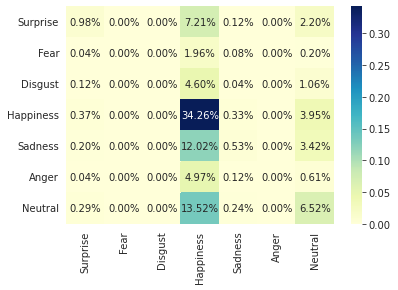

In [ ]:
# Get the Bag of visual words
initialize_bovw = SiftBoVW(X_train, y_train)
x_hist_train, y_hist_train = initialize_bovw.get()
# Train the classifier
classifier = svm.SVC(kernel='rbf')
classifier.fit(x_hist_train, y_hist_train)
# Get features for the validation dataset
X_hist_val, y_hist_val = initialize_bovw.test(X_val, y_val)
# Get prediction on validation set
y_pred_val = classifier.predict(X_hist_val).tolist()
# Plot confusion matrix
plot_classification(y_hist_val, y_pred_val)

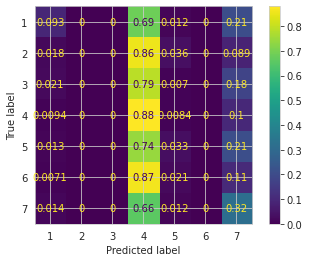

In [ ]:
metrics.ConfusionMatrixDisplay.from_predictions(y_hist_val, y_pred_val, normalize='true')

The classifier is overwhelmed by the class imbalance. All of the other classes are being classified as 4:Happinness with 7:Neutral picking up the reamining slack

## 💪 Step 2️⃣. Train on SVM

Although the accuracy is 44% most of the prediction is overwhelmed by the Happiness. The macro F1 score of 0.15 suggests the prediction of most of the classes is quite poor.

In [ ]:
f1_normal = metrics.f1_score(y_hist_val, y_pred_val,average=None)
balance_acc_normal = metrics.balanced_accuracy_score(y_hist_val, y_pred_val)
metrics_all['normal'] = {'f1_class': f1_normal, 'balance_accuracy' : balance_acc_normal}

In [ ]:
 labels = ['Surprise','Fear','Disgust',
'Happiness','Sadness','Anger','Neutral']

## 🔀 Step 3️⃣. Resampling Techniques

We try two different resampling techniques namely RandomUnderSampling and RandomOverSampling

## First UnderSampling

In [ ]:
#adapted from https://stackoverflow.com/questions/48532069/how-to-oversample-image-dataset-using-python
# X : current_dataset
# y : labels

#RandomUnderSampler
#reshape X
reshaped_X = X_train.reshape(X_train.shape[0],-1)

#oversampling
undersample = RandomUnderSampler()
undersampled_X, undersample_y  = undersample.fit_resample(reshaped_X , y_train)

# reshaping X back to the first dims
undersample_X = undersampled_X.reshape(-1,100,100,3)
print(undersample_X.shape, undersample_y.shape)


(1575, 100, 100, 3) (1575,)


Extracting SIFT descriptors:   0%|          | 0/1575 [00:00<?, ?it/s]

97646
24411


Predicting Clusters:   0%|          | 0/1574 [00:00<?, ?it/s]

Extracting clusters for Test:   0%|          | 0/2455 [00:00<?, ?it/s]

Classification report for classifier SVM-BoVW on train set:
                        precision    recall  f1-score   support

           1       0.22      0.31      0.26       258
           2       0.06      0.36      0.11        56
           3       0.10      0.27      0.15       143
           4       0.61      0.24      0.34       955
           5       0.23      0.16      0.19       397
           6       0.11      0.21      0.14       141
           7       0.33      0.31      0.32       505

    accuracy                           0.25      2455
   macro avg       0.24      0.27      0.22      2455
weighted avg       0.38      0.25      0.28      2455




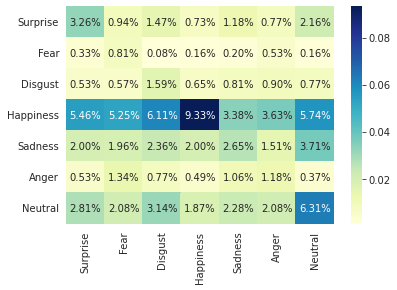

In [ ]:
# Get the Bag of visual words
initialize_bovw = SiftBoVW(undersample_X, undersample_y)
x_hist_train, y_hist_train = initialize_bovw.get()
# Train the classifier
classifier = svm.SVC(kernel='rbf')
classifier.fit(x_hist_train, y_hist_train)
# Get features for the validation dataset
X_hist_val, y_hist_val = initialize_bovw.test(X_val, y_val)
# Get prediction on validation set
y_pred_val = classifier.predict(X_hist_val).tolist()
# Plot confusion matrix
plot_classification(y_hist_val, y_pred_val)

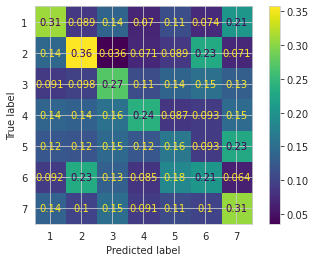

In [ ]:
metrics.ConfusionMatrixDisplay.from_predictions(y_hist_val, y_pred_val, normalize='true')

The overall accuracy has decreased by almost half however the model does not rely on predicting just one class. A macro F1 score of 0.21 suggests the model is better with differentiating between the classes.

In [ ]:
f1_undersample = metrics.f1_score(y_hist_val, y_pred_val,average=None)
balance_acc_undersample = metrics.balanced_accuracy_score(y_hist_val, y_pred_val)
metrics_all['undersample'] = {'f1_class': f1_undersample, 'balance_accuracy' : balance_acc_undersample}

In [ ]:
f1_undersample

array([0.252149  , 0.06818182, 0.13849287, 0.32826748, 0.18639053,
       0.17427386, 0.28826816])

## Next Random OverSampling

In [60]:
#adapted from https://stackoverflow.com/questions/48532069/how-to-oversample-image-dataset-using-python
# X : current_dataset
# y : labels

#RandomUnderSampler
#reshape X
reshaped_X = X_train.reshape(X_train.shape[0],-1)

#oversampling
oversample = RandomOverSampler()
oversampled_X, oversample_y  = oversample.fit_resample(reshaped_X , y_train)

# reshaping X back to the first dims
oversample_X = oversampled_X.reshape(-1,100,100,3)
print(oversample_X.shape, oversample_y.shape)


(26719, 100, 100, 3) (26719,)


In [ ]:
oversample_X.shape

(26719, 100, 100, 3)

In [ ]:
wandb: 	C: 976.3349976290592
wandb: 	gamma: 0.09963986295371566
wandb: 	kernel: rbf

In [68]:
clf.predict(X_hist_val)

KeyboardInterrupt: ignored

Extracting SIFT descriptors:   0%|          | 0/26719 [00:00<?, ?it/s]

Number of descriptors: 1632544.
K-Means batch size: 408136.


Predicting Clusters:   0%|          | 0/26693 [00:00<?, ?it/s]

Extracting clusters for Test:   0%|          | 0/2455 [00:00<?, ?it/s]

Classification report for classifier SVM-BoVW on train set:
                        precision    recall  f1-score   support

           1       0.24      0.39      0.30       258
           2       0.05      0.29      0.08        56
           3       0.11      0.29      0.16       143
           4       0.63      0.28      0.39       955
           5       0.27      0.21      0.23       397
           6       0.13      0.27      0.18       141
           7       0.40      0.24      0.30       505

    accuracy                           0.27      2455
   macro avg       0.26      0.28      0.23      2455
weighted avg       0.41      0.27      0.30      2455




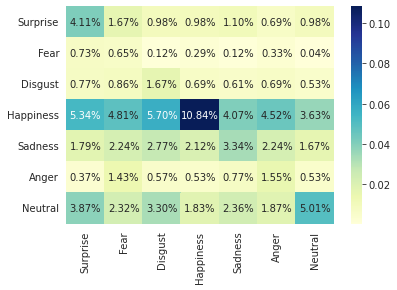

In [61]:
# Get the Bag of visual words
initialize_bovw = SiftBoVW(oversample_X, oversample_y)
x_hist_train, y_hist_train = initialize_bovw.get()
# Train the classifier
classifier = svm.SVC(kernel='rbf', C=976.3349976290592, gamma=0.09963986295371566)
classifier.fit(x_hist_train, y_hist_train)
# Get features for the validation dataset
X_hist_val, y_hist_val = initialize_bovw.test(X_val, y_val)
# Get prediction on validation set
y_pred_val = classifier.predict(X_hist_val).tolist()
# Plot confusion matrix
plot_classification(y_hist_val, y_pred_val)

In [65]:
from joblib import dump, load


In [64]:
from joblob import load

ModuleNotFoundError: ignored

In [67]:
clf = load(filename) 

In [62]:
filename = os.path.join(GOOGLE_DRIVE_PATH, 'Models/svm_sift_model.joknkmknknblib')
joblib.dump(classifier, filename)

['drive/My Drive/Computer Vision Coursework/CW_Folder_PG/Models/svm_sift_model.joblib']

wandb: 	C: 837.7796847753427
wandb: 	gamma: 0.7180404446955007
wandb: 	kernel: poly

Extracting clusters for Test:   0%|          | 0/2455 [00:00<?, ?it/s]

Classification report for classifier SVM-BoVW on train set:
                        precision    recall  f1-score   support

           1       0.22      0.26      0.24       258
           2       0.04      0.29      0.07        56
           3       0.09      0.27      0.14       143
           4       0.57      0.32      0.41       955
           5       0.24      0.14      0.18       397
           6       0.12      0.33      0.17       141
           7       0.37      0.15      0.21       505

    accuracy                           0.25      2455
   macro avg       0.24      0.25      0.20      2455
weighted avg       0.37      0.25      0.28      2455




0.2515348941837171

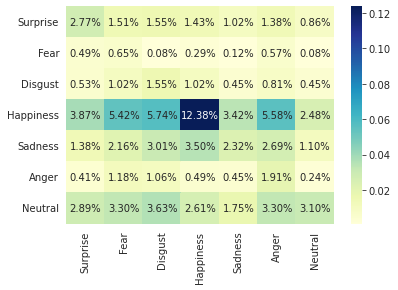

In [16]:
classifier = svm.SVC(kernel='poly', C=837.7796847753427, gamma=0.7180404446955007)
classifier.fit(x_hist_train, y_hist_train)
# Get features for the validation dataset
X_hist_val, y_hist_val = initialize_bovw.test(X_val, y_val)
# Get prediction on validation set
y_pred_val = classifier.predict(X_hist_val).tolist()
# Plot confusion matrix
plot_classification(y_hist_val, y_pred_val)
metrics.balanced_accuracy_score(y_hist_val,y_pred_val)

In [17]:
import joblib
filename = os.path.join(GOOGLE_DRIVE_PATH, 'Models/svm_sift_class.joblib')
joblib.dump(initialize_bovw, filename)
filename = os.path.join(GOOGLE_DRIVE_PATH, 'Models/svm_sift_model.joblib')
joblib.dump(classifier, filename)




TypeError: ignored

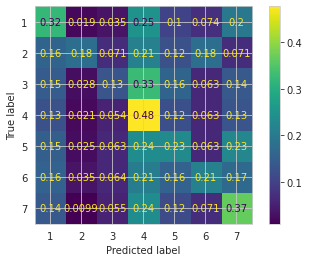

In [ ]:
metrics.ConfusionMatrixDisplay.from_predictions(y_hist_val, y_pred_val, normalize='true')

In [ ]:
metrics_all['oversample']

{'balance_accuracy': 0.274855773836033,
 'f1_class': array([0.25736434, 0.17391304, 0.13148789, 0.51322454, 0.2486631 ,
        0.18181818, 0.36779324])}

In [ ]:
f1_oversample = metrics.f1_score(y_hist_val, y_pred_val,average=None)
balance_acc_oversample = metrics.balanced_accuracy_score(y_hist_val, y_pred_val)
metrics_all['oversample'] = {'f1_class': f1_oversample, 'balance_accuracy' : balance_acc_oversample}

In [ ]:
metrics_all['oversample']['f1_class']

{'normal': {'balance_accuracy': 0.18903268616758942,
  'f1_class': array([0.15584416, 0.        , 0.        , 0.58342005, 0.06004619,
         0.        , 0.33826638])},
 'oversample': {'balance_accuracy': 0.274855773836033,
  'f1_class': array([0.25736434, 0.17391304, 0.13148789, 0.51322454, 0.2486631 ,
         0.18181818, 0.36779324])},
 'undersample': {'balance_accuracy': 0.2651529481140705,
  'f1_class': array([0.25641026, 0.10695187, 0.14885496, 0.34462002, 0.19089574,
         0.1446384 , 0.31729785])}}

In [ ]:
result.index += 1 

In [ ]:
result_pd = pd.DataFrame.from_dict(metrics_all, orient= 'index').explode('f1_class').reset_index()
result_pd.index += 1 
result_pd = result_pd.reset_index()

In [ ]:
result_pd['level_0'] = result_pd['level_0'].iloc[0:7] 

In [ ]:
result_pd

,level_0,index,f1_class,balance_accuracy
0,1,normal,0.155844,0.189033
1,2,normal,0.0,0.189033
2,3,normal,0.0,0.189033
3,4,normal,0.58342,0.189033
4,5,normal,0.060046,0.189033
5,6,normal,0.0,0.189033
6,7,normal,0.338266,0.189033
7,8,undersample,0.25641,0.265153
8,9,undersample,0.106952,0.265153
9,10,undersample,0.148855,0.265153


/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


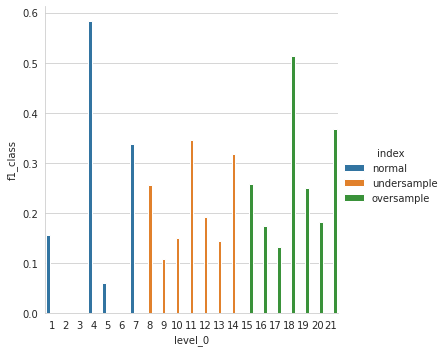

In [ ]:
sns.factorplot(x='level_0', y='f1_class', hue='index', data=result_pd, kind='bar')


The best results were by oversampling technique.


## 📊 Step 4️⃣. HOG on SVM

We'll run the training on the oversampled dataset as it proved most promising

In [52]:
# Extract HOG features for training set
hog_list_xtrain = []
for image in oversample_X:
    hos_descriptor =  hog(image,
                          orientations=9,
                          pixels_per_cell=(8, 8),
                          cells_per_block=(1, 1),
                          feature_vector = True,
                          visualize=False,
                          transform_sqrt=True,
                          multichannel=True)
    hog_list_xtrain.append(hos_descriptor) 

In [53]:
# Doing the same for the Test set
hog_list_xval = []
for image in X_val:
    hos_descriptor =  hog(image,
                          orientations=9,
                          pixels_per_cell=(8, 8),
                          cells_per_block=(1, 1),
                          feature_vector = True,
                          visualize=False,
                          transform_sqrt=True,
                          multichannel=True)
    hog_list_xval.append(hos_descriptor) 

In [54]:
# Train on the HOG features
classifier = svm.SVC(kernel='rbf')
classifier.fit(hog_list_xtrain, oversample_y)

KeyboardInterrupt: ignored

In [ ]:
y_pred_hog_val = classifier.predict(hog_list_xval).tolist()
plot_classification(y_pred_hog_val, y_val)

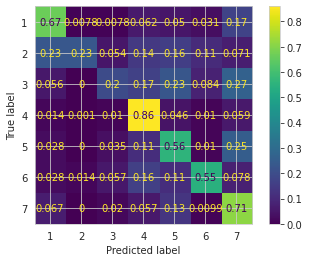

In [ ]:
metrics.ConfusionMatrixDisplay.from_predictions(y_val, y_pred_hog_val, normalize='true')

## 🎼 Step 5️⃣. Hyper-paramter Tuning

I'll use wandb.io which is pretty great for automating the search for the different parameters

In [ ]:
counts = np.bincount(y_train)

In [48]:
metric = {
    'name': 'loss',
    'goal': 'minimize'   
    }

sweep_config['metric'] = metric

In [ ]:
param_grid = { 'C':[0.1,1,100,1000],'kernel':['rbf','poly','sigmoid','linear'],'degree':[1,2,3,4,5,6],'gamma': [1, 0.1, 0.01, 0.001, 0.0001]}


In [45]:
import wandb

sweep_config = {
  "name" : "SVM-HOG",
  "method" : "random",
  "parameters" : {
    "kernel" : {
      "values" : ['poly']
    },
    "C" :{
      'distribution': 'uniform',
      "min": 100,
      "max": 10000
    },
    'gamma':{
        'distribution': 'uniform',
        "min": 0.0001,
        "max" : 1
    }
    }
  }


sweep_id = wandb.sweep(sweep_config)

Create sweep with ID: sxa47a3d
Sweep URL: https://wandb.ai/baber/HOG-SVM-Not-Class%20balanced1/sweeps/sxa47a3d


In [20]:
metric = {
    'name': 'balanced accuracy_score',
    'goal': 'maximize'   
    }

sweep_config['metric'] = metric

In [ ]:
sweep_id = wandb.sweep(sweep_config, project="HOG-SVM-Not-Balanced")

Create sweep with ID: cs1kcm5l
Sweep URL: https://wandb.ai/baber/HOG-SVM-Not-Balanced/sweeps/cs1kcm5l


In [51]:
def train():
    from sklearn import svm, metrics
    with wandb.init() as run:
        config = wandb.config
        model = svm.SVC(kernel=config['kernel'],
                        class_weight='balanced',
                        C=config['C'],
                        gamma = config['gamma'],

                        )
        model.fit(x_hist_train, y_hist_train)
        y_pred_hog_val = model.predict(y_hist_val).tolist() 


        wandb.log({'balanced accuracy_score': metrics.balanced_accuracy_score(y_val, y_pred_hog_val),
               'f1 scores': metrics.f1_score(y_val, y_pred_hog_val, average=None)})
count = 15 # number of runs to execute
wandb.agent(sweep_id, function=train, count=count)

wandb: Agent Starting Run: wobx550n with config:
wandb: 	C: 7341.43619235976
wandb: 	gamma: 0.5452019978287862
wandb: 	kernel: poly


wandb: ERROR Run wobx550n errored: ValueError('Expected 2D array, got 1D array instead:\narray=[2. 7. 7. ... 7. 3. 5.].\nReshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.')
wandb: Agent Starting Run: ndasou7n with config:
wandb: 	C: 9501.810213434112
wandb: 	gamma: 0.25763864863303926
wandb: 	kernel: poly


wandb: ERROR Run ndasou7n errored: ValueError('Expected 2D array, got 1D array instead:\narray=[2. 7. 7. ... 7. 3. 5.].\nReshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.')
wandb: Ctrl + C detected. Stopping sweep.


In [23]:
sweep_id = wandb.sweep(sweep_config, project="HOG-SVM-Not-Class balanced1")

Create sweep with ID: xga8z6xw
Sweep URL: https://wandb.ai/baber/HOG-SVM-Not-Class%20balanced1/sweeps/xga8z6xw


In [46]:
# output on https://wandb.ai/baber/HOG-SVM-Not-Class%20balanced/sweeps/q0u2wu29?workspace=user-baber
def train():
    best_balance_accuracy = -1
    from sklearn import svm, metrics
    with wandb.init() as run:
        config = wandb.config
        model = svm.SVC(kernel=config['kernel'],
                        C=config['C'],
                        gamma = config['gamma'],

                        )
        model.fit(hist_array, y_train_list)
        y_pred_hog_val = model.predict(hist_array_val).tolist() 
        bb = metrics.balanced_accuracy_score(y_test_val, y_pred_hog_val)
        labels = ['Surprise', 'Fear', 'Disgust', 'Happiness', 'Sadness', 'Anger', 'Neutral']
        wandb.log({'balanced accuracy_score': metrics.balanced_accuracy_score(y_test_val, y_pred_hog_val),
               'f1 scores': metrics.f1_score(y_test_val, y_pred_hog_val, average=None),
                'accuracy' : metrics.accuracy_score(y_test_val, y_pred_hog_val, normalize=True)})
        
        if bb > best_balance_accuracy:
          bb=best_balance_accuracy
          filename = os.path.join(GOOGLE_DRIVE_PATH, 'Models/svm_sift_model.joblib')
          joblib.dump(classifier, filename)

count = 10 # number of runs to execute
wandb.agent(sweep_id, function=train, count=count)

wandb: Agent Starting Run: bdv849jf with config:
wandb: 	C: 7772.219571155848
wandb: 	gamma: 0.6641990807934711
wandb: 	kernel: poly


accuracy,▁
balanced accuracy_score,▁
accuracy,0.29165
balanced accuracy_score,0.28386


wandb: Agent Starting Run: 1wn0vt83 with config:
wandb: 	C: 5483.9783147902535
wandb: 	gamma: 0.225365197214449
wandb: 	kernel: poly


accuracy,▁
balanced accuracy_score,▁
accuracy,0.1666
balanced accuracy_score,0.14662


wandb: Agent Starting Run: bjgam6mj with config:
wandb: 	C: 692.088472571726
wandb: 	gamma: 0.13337482078036278
wandb: 	kernel: poly
wandb: ERROR Error while calling W&B API: Error 1040: Too many connections (<Response [500]>)
wandb: ERROR Error communicating with wandb process
wandb: ERROR try: wandb.init(settings=wandb.Settings(start_method='fork'))
wandb: ERROR or:  wandb.init(settings=wandb.Settings(start_method='thread'))
wandb: ERROR For more info see: https://docs.wandb.ai/library/init#init-start-error
wandb: ERROR Run bjgam6mj errored: UsageError("Error communicating with wandb process\ntry: wandb.init(settings=wandb.Settings(start_method='fork'))\nor:  wandb.init(settings=wandb.Settings(start_method='thread'))\nFor more info see: https://docs.wandb.ai/library/init#init-start-error")


Problem at: <ipython-input-46-13c9f9cbc180> 5 train


wandb: Agent Starting Run: a7b9su4j with config:
wandb: 	C: 6702.168548910609
wandb: 	gamma: 0.4304882644862604
wandb: 	kernel: poly


accuracy,▁
balanced accuracy_score,▁
accuracy,0.2668
balanced accuracy_score,0.27081


wandb: Agent Starting Run: fxrah37u with config:
wandb: 	C: 3604.5820352773935
wandb: 	gamma: 0.5383703364810405
wandb: 	kernel: poly


accuracy,▁
balanced accuracy_score,▁
accuracy,0.26599
balanced accuracy_score,0.26873


wandb: Agent Starting Run: hgssj7gy with config:
wandb: 	C: 2641.6138736635476
wandb: 	gamma: 0.16028863399897866
wandb: 	kernel: poly


accuracy,▁
balanced accuracy_score,▁
accuracy,0.16171
balanced accuracy_score,0.14286


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: bdovyzkw with config:
wandb: 	C: 136.29106927168712
wandb: 	gamma: 0.6265035081882966
wandb: 	kernel: poly


accuracy,▁
balanced accuracy_score,▁
accuracy,0.16171
balanced accuracy_score,0.14286


wandb: Agent Starting Run: gbfwdk0x with config:
wandb: 	C: 293.7793764938298
wandb: 	gamma: 0.42003161877567474
wandb: 	kernel: poly


accuracy,▁
balanced accuracy_score,▁
accuracy,0.16171
balanced accuracy_score,0.14286


wandb: Agent Starting Run: onijt26z with config:
wandb: 	C: 1063.1234703727114
wandb: 	gamma: 0.8623381446440271
wandb: 	kernel: poly


accuracy,▁
balanced accuracy_score,▁
accuracy,0.26843
balanced accuracy_score,0.2721


wandb: Agent Starting Run: in15s68h with config:
wandb: 	C: 7163.58845365028
wandb: 	gamma: 0.6305899375007088
wandb: 	kernel: poly


accuracy,▁
balanced accuracy_score,▁
accuracy,0.2888
balanced accuracy_score,0.28312


A plot of one of the runs is shown below. A polynomial kernel works best along side a Gamma on the higher side as well as high C.


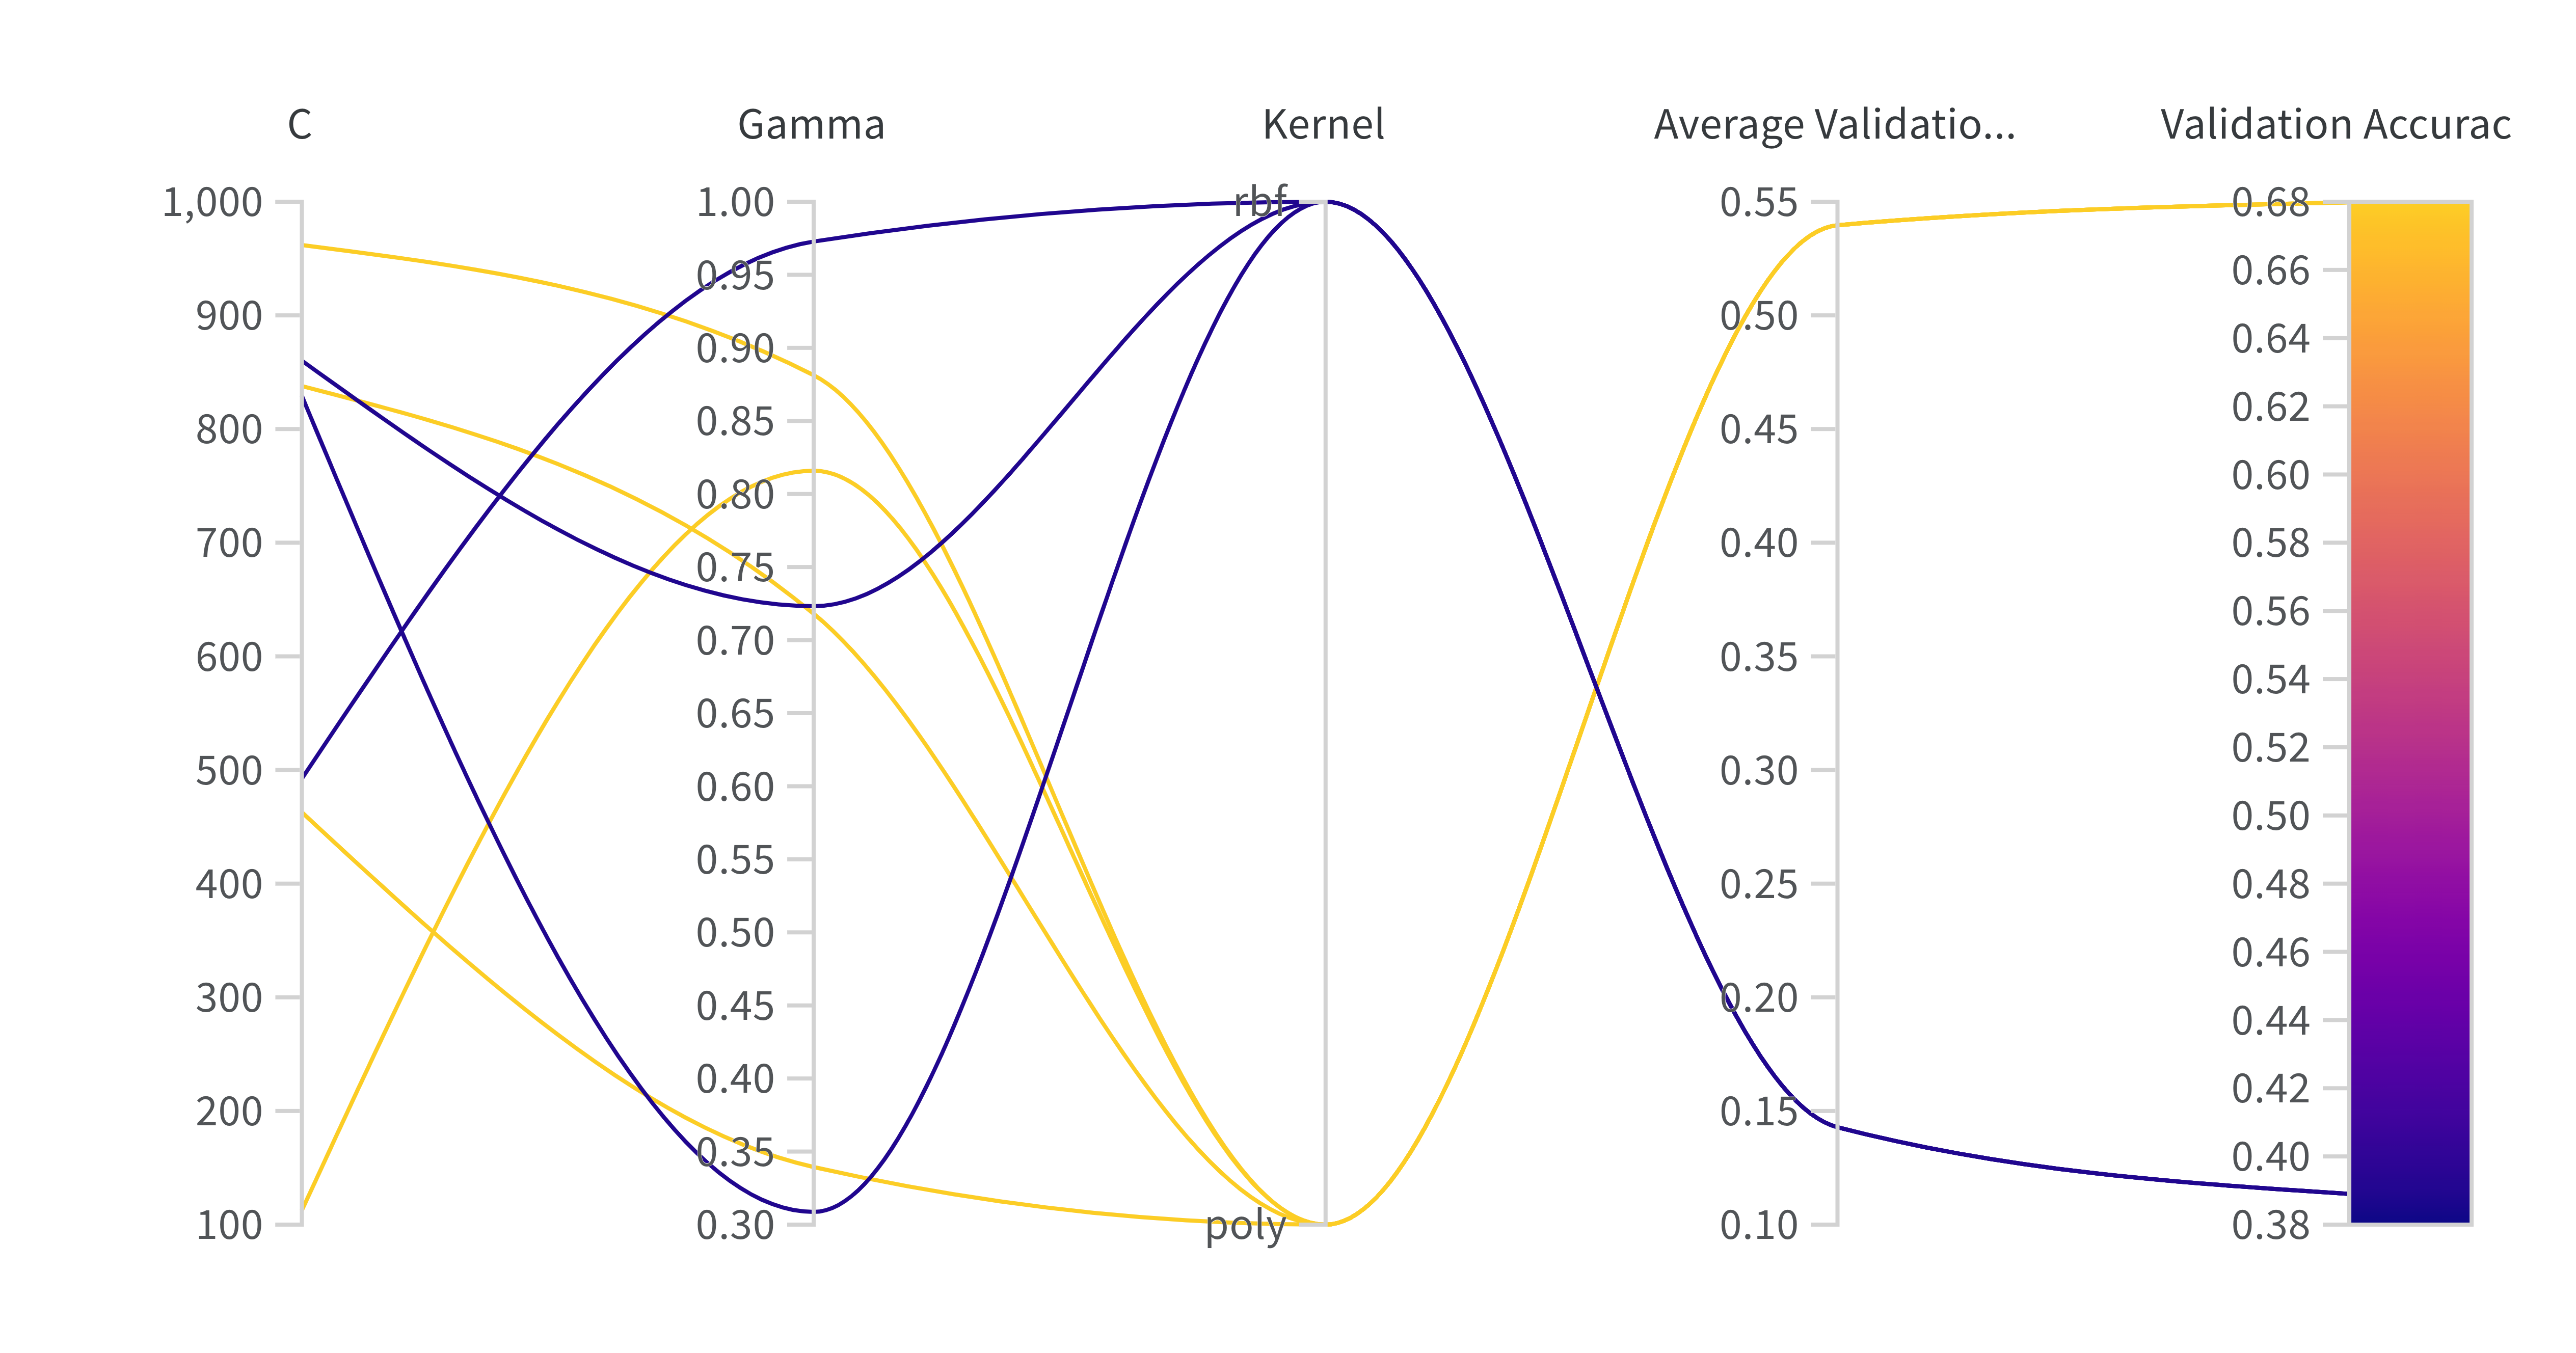

Train

In [39]:
#Taken from Lab 07, Computer Vision https://colab.research.google.com/drive/1jF4LQk2dIFnhLjvA1ZcnmLBRqSe150_N#scrollTo=hxOWhrRg54Tf
# Initiate SIFT detector
sift = cv2.SIFT_create()

# Create empty lists for feature descriptors and labels
des_list = []
y_train_list = []


for i in range(len(oversample_X)):
    # Identify keypoints and extract descriptors with SIFT
    img = img_as_ubyte(color.rgb2gray(oversample_X[i]))
    kp, des = sift.detectAndCompute(img, None)

    # Append list of descriptors and label to respective lists
    if des is not None:
        des_list.append(des)
        y_train_list.append(oversample_y[i])

# Convert to array for easier handling
des_array = np.vstack(des_list)

In [40]:
des_array = np.vstack(des_list)

In [57]:
# Number of centroids/codewords: good rule of thumb is 10*num_classes
k = len(np.unique(oversample_y)) * 10
print(k)

# Use MiniBatchKMeans for faster computation and lower memory usage
batch_size = des_array.shape[0] // 4
kmeans = MiniBatchKMeans(n_clusters=k, batch_size=batch_size).fit(des_array)

70


In [58]:
filename = os.path.join(GOOGLE_DRIVE_PATH, 'Models/svm_sift_kmeans.joblib')
joblib.dump(kmeans, filename)

['drive/My Drive/Computer Vision Coursework/CW_Folder_PG/Models/svm_sift_kmeans.joblib']

In [55]:
x = kmeans.predict(des)

In [59]:
# Convert descriptors into histograms of codewords for each image
hist_list = []
idx_list = []

for des in des_list:
    hist = np.zeros(k)

    idx = kmeans.predict(des)
    idx_list.append(idx)
    for j in idx:
        hist[j] = hist[j] + (1 / len(des))
    hist_list.append(hist)

hist_array = np.vstack(hist_list)

In [47]:
filename = os.path.join(GOOGLE_DRIVE_PATH, 'Models/svm_sift_kmeans.joblib')
joblib.dump(classifier, filename)

['drive/My Drive/Computer Vision Coursework/CW_Folder_PG/Models/svm_sift_kmeans.joblib']

In [ ]:
# Create a classifier: a support vector classifier
classifier = svm.SVC(kernel='rbf')

# We learn the digits on the first half of the digits
classifier.fit(hist_array, y_train_list)

In [43]:
hist_list_val = []

for i in range(len(X_val)):
    img = img_as_ubyte(color.rgb2gray(X_val[i]))
    kp, des = sift.detectAndCompute(img, None)

    if des is not None:
        hist = np.zeros(k)

        idx = kmeans.predict(des)

        for j in idx:
            hist[j] = hist[j] + (1 / len(des))

        # hist = scale.transform(hist.reshape(1, -1))
        hist_list_val.append(hist)

    else:
        hist_list_val.append(None)

# Remove potential cases of images with no descriptors
idx_not_empty = [i for i, x in enumerate(hist_list_val) if x is not None]
hist_list_val = [hist_list_val[i] for i in idx_not_empty]
y_test_val = [y_val[i] for i in idx_not_empty]
hist_array_val = np.vstack(hist_list_val)

In [ ]:
def SVM_tuner(x_train,
              y_train,
              x_test,
              y_test,
              kernel,
              weights,):
    print('Training on SVM')

    classifier = svm.SVC(kernel=kernel,class_weight=weights)
    classifier.fit(hog_list_xtrain, y_train)

    preds = classifier.predict(x_val)
    pred_prob = classifier.predict_proba(x_test)

    print(metrics.classification_report(y_test, preds))
    wandb.log({'balanced accuracy_score': metrics.balanced_accuracy_score(y_val, y_pred_hog_val),
               'f1 scores': metrics.metrics.f1_score(y_val, y_pred_hog_val, average=None),
               "conf_mat" : wandb.plot.confusion_matrix(probs=None,
                            preds=top_pred_ids, y_true=ground_truth_class_ids,
                            class_names=self.flat_class_names)})
    labels = ['Surprise', 'Fear', 'Disgust', 'Happiness', 'Sadness', 'Anger', 'Neutral']
    wandb.sklearn.plot_classifier(classifier, X_train, x_test, y_train, y_test, preds, pred_prob, classifier.classes_,
                                  model_name='LogisticRegression', feature_names=None)

In [ ]:
wandb: 	C: 976.3349976290592
wandb: 	gamma: 0.09963986295371566
wandb: 	kernel: rbf